references:  
https://www.kaggle.com/code/sorkun/house-prices-simple-workflow-lb-0-12426  
https://www.kaggle.com/code/niteshx2/top-50-beginners-stacking-lgb-xgb/notebook  
https://www.kaggle.com/code/jesucristo/1-house-prices-solution-top-1/notebook?scriptVersionId=12846740


## initialize
data <-train.csv  
test <-test.csv

In [220]:
import numpy as np 
import pandas as pd 
#UTILS
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.stats import skew
#MODELS
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xg
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats


import warnings
warnings.filterwarnings('ignore')

In [221]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [222]:
data = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")

data_b = data.drop(['Id'], axis=1) 
test_b = test.drop(['Id'], axis=1) 
data_b.head()
data['SalePrice'].isnull().sum()

0

In [223]:
test_b.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
1458,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,TA,TA,PConc,Gd,TA,Av,LwQ,758.0,Unf,0.0,238.0,996.0,GasA,Ex,Y,SBrkr,996,1004,0,2000,0.0,0.0,2,1,3,1,TA,9,Typ,1,TA,Attchd,1993.0,Fin,3.0,650.0,TA,TA,Y,190,48,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [224]:
data_b.shape, test_b.shape

((1460, 80), (1459, 79))

In [225]:
concat = pd.concat([data, test]).reset_index(drop=True)
concat = concat.drop(['Id'], axis=1)
#concat.head()
concat.shape

(2919, 80)

## data research

In [226]:
# Analyse missing Values
# data.info()
# data_b.isnull().sum().sort_values(ascending=False).head(20)

missing_data = pd.concat([data_b.isnull().sum(), data_b.dtypes], axis=1, keys=['Missing Values', 'Data Type'])
missing_data.sort_values('Missing Values', ascending=False).head(20)

,Missing Values,Data Type
PoolQC,1453,object
MiscFeature,1406,object
Alley,1369,object
Fence,1179,object
FireplaceQu,690,object
LotFrontage,259,float64
GarageYrBlt,81,float64
GarageCond,81,object
GarageType,81,object
GarageFinish,81,object


In [227]:
#Split Columns: Categorical / Numeric
cols = data_b.columns
numeric_columns, categorical_columns = [], []
for i in range(len(cols)):
    if data_b[cols[i]].dtypes == 'O':
        categorical_columns.append(cols[i])
    else:
        numeric_columns.append(cols[i])

#Show Unique items in categorical variables
category_analysis = pd.DataFrame(categorical_columns, columns = ["Feature"])
unique_values = []
unique_counts = []
for col in categorical_columns:
    unique_values.append(data_b[col].unique())
    unique_counts.append(len(data_b[col].unique()))
    
category_analysis["Categories"] = unique_values
category_analysis["Number"] = unique_counts
category_analysis

,Feature,Categories,Number
0,MSZoning,"[RL, RM, C (all), FV, RH]",5
1,Street,"[Pave, Grvl]",2
2,Alley,"[nan, Grvl, Pave]",3
3,LotShape,"[Reg, IR1, IR2, IR3]",4
4,LandContour,"[Lvl, Bnk, Low, HLS]",4
5,Utilities,"[AllPub, NoSeWa]",2
6,LotConfig,"[Inside, FR2, Corner, CulDSac, FR3]",5
7,LandSlope,"[Gtl, Mod, Sev]",3
8,Neighborhood,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ...",25
9,Condition1,"[Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, ...",9


In [228]:
# show "categorical feature with missing value" value calculation
for i in categorical_columns:
    if data[i].isna().sum() > 0:
        print(i)
        print("Number of missing values:", data[i].isna().sum())
        print("Percentage of missing values:", round(data[i].isna().sum() / len(data) * 100, 2), "%")
        print(data[i].value_counts(dropna=False), '\n')
    #else:
    #    print(i)
    #    print(data[i].value_counts(), '\n')

Alley
Number of missing values: 1369
Percentage of missing values: 93.77 %
NaN     1369
Grvl      50
Pave      41
Name: Alley, dtype: int64 

MasVnrType
Number of missing values: 8
Percentage of missing values: 0.55 %
None       864
BrkFace    445
Stone      128
BrkCmn      15
NaN          8
Name: MasVnrType, dtype: int64 

BsmtQual
Number of missing values: 37
Percentage of missing values: 2.53 %
TA     649
Gd     618
Ex     121
NaN     37
Fa      35
Name: BsmtQual, dtype: int64 

BsmtCond
Number of missing values: 37
Percentage of missing values: 2.53 %
TA     1311
Gd       65
Fa       45
NaN      37
Po        2
Name: BsmtCond, dtype: int64 

BsmtExposure
Number of missing values: 38
Percentage of missing values: 2.6 %
No     953
Av     221
Gd     134
Mn     114
NaN     38
Name: BsmtExposure, dtype: int64 

BsmtFinType1
Number of missing values: 37
Percentage of missing values: 2.53 %
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
NaN     37
Name: BsmtFinType1, dty

<AxesSubplot:>

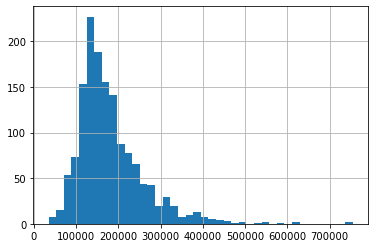

In [229]:
data['SalePrice'].hist(bins = 40)

<AxesSubplot:>

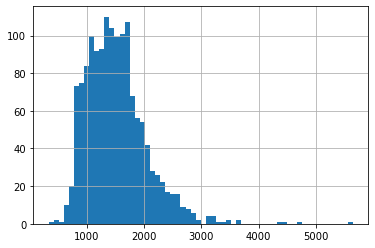

In [230]:
data['GrLivArea'].hist(bins = 60)

scipy.stats.johnsonsu 是 Johnson SU distribution 的機率密度函數 (probability density function, PDF)。Johnson SU distribution 是一種連續機率分布，可以用來建模具有左偏或右偏的非對稱資料。這種分布由 Johnson 在 1949 年提出，它將任意分布的值，透過一個標準正態分布的轉換，使得轉換後的值符合 Johnson SU distribution。

<AxesSubplot:title={'center':'Log Normal'}, xlabel='SalePrice'>

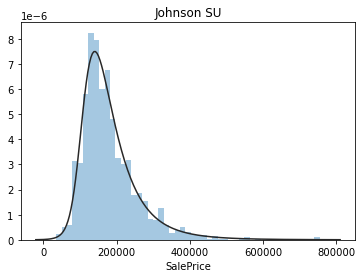

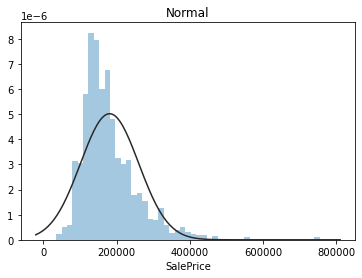

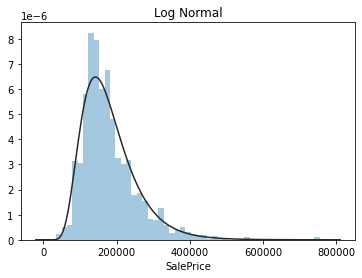

In [231]:
y = data['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

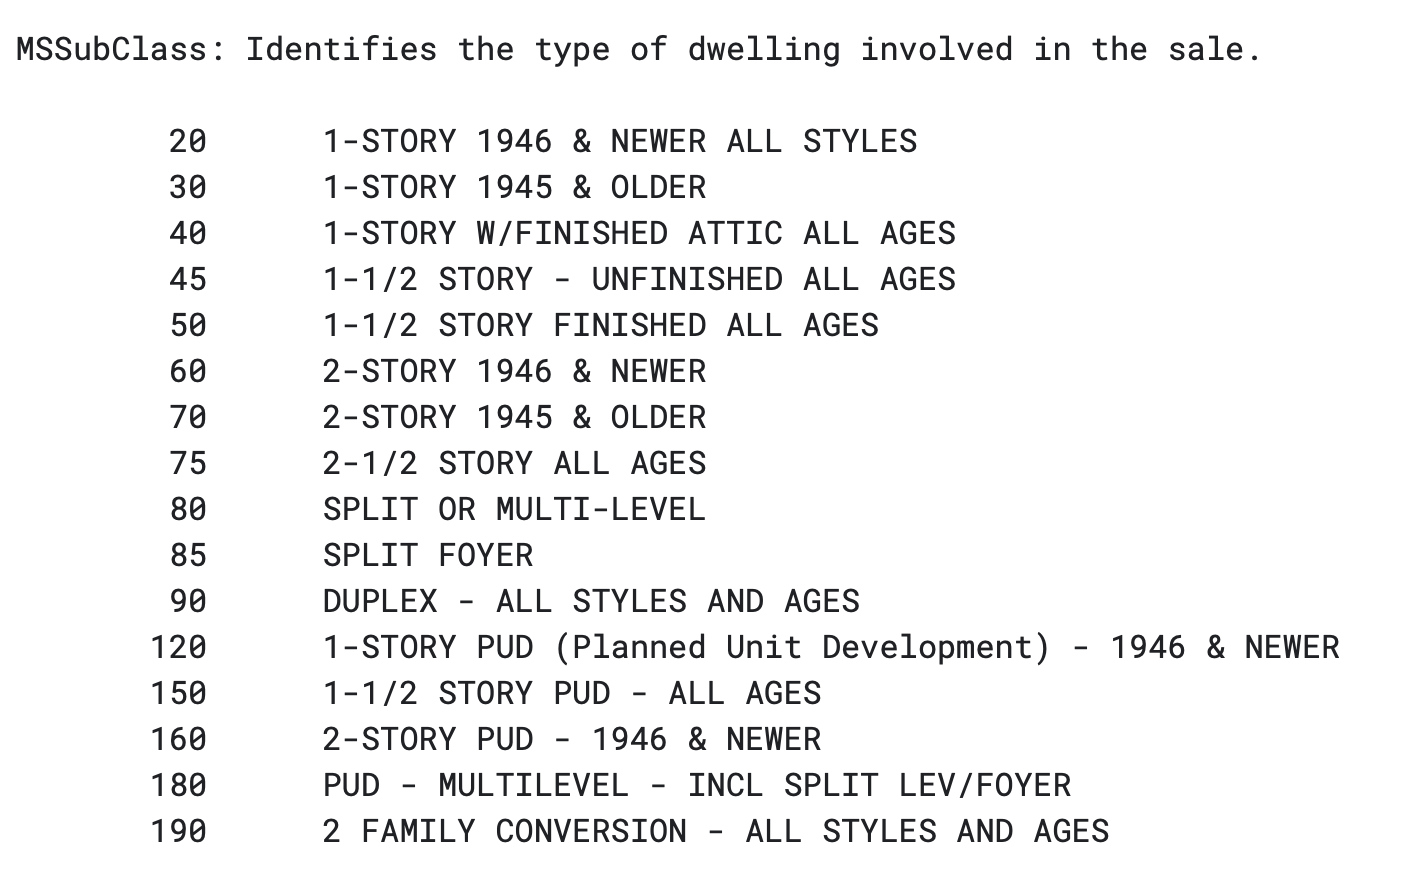
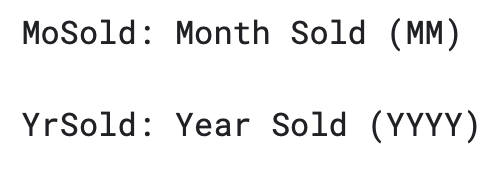

In [232]:
data['MSSubClass'] = data['MSSubClass'].apply(str)
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)
concat['MSSubClass'] = concat['MSSubClass'].apply(str)
concat['YrSold'] = concat['YrSold'].astype(str)
concat['MoSold'] = concat['MoSold'].astype(str)

In [233]:
quantitative = [f for f in data.columns if data.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in data.columns if data.dtypes[f] == 'object']

In [234]:
data_c = data

這段程式碼是對質性特徵進行編碼的過程。首先定義了一個encode()函數，該函數會將質性特徵轉換為有序特徵（即用1至n的數字來表示特徵的大小關係），轉換過程根據SalePrice的平均值排序得到的順序。之後，使用for循環遍歷所有質性特徵，調用encode()函數將質性特徵轉換為有序特徵，並將編碼後的特徵名添加到列表qual_encoded中。

In [235]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(data_c, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSSubClass_E', 'MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'MoSold_E', 'YrSold_E', 'SaleType_E', 'SaleCondition_E']


In [236]:
data_c.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,MSSubClass_E,MSZoning_E,Street_E,Alley_E,LotShape_E,LandContour_E,Utilities_E,LotConfig_E,LandSlope_E,Neighborhood_E,Condition1_E,Condition2_E,BldgType_E,HouseStyle_E,RoofStyle_E,RoofMatl_E,Exterior1st_E,Exterior2nd_E,MasVnrType_E,ExterQual_E,ExterCond_E,Foundation_E,BsmtQual_E,BsmtCond_E,BsmtExposure_E,BsmtFinType1_E,BsmtFinType2_E,Heating_E,HeatingQC_E,CentralAir_E,Electrical_E,KitchenQual_E,Functional_E,FireplaceQu_E,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,MoSold_E,YrSold_E,SaleType_E,SaleCondition_E
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,15.0,4.0,2.0,NaN,1.0,2.0,2.0,1.0,1.0,17.0,5.0,5.0,5.0,7.0,2.0,3.0,12.0,13.0,3.0,3.0,4.0,6.0,3.0,3.0,1.0,6.0,5.0,6.0,5.0,2.0,5.0,3.0,7.0,NaN,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,4.0,1.0,5.0,5.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,12.0,4.0,2.0,NaN,1.0,2.0,2.0,2.0,1.0,21.0,3.0,5.0,5.0,6.0,2.0,3.0,5.0,6.0,2.0,2.0,4.0,3.0,3.0,3.0,4.0,4.0,5.0,6.0,5.0,2.0,5.0,2.0,7.0,3.0,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,2.0,5.0,5.0,5.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,15.0,4.0,2.0,NaN,2.0,2.0,2.0,1.0,1.0,17.0,5.0,5.0,5.0,7.0,2.0,3.0,12.0,13.0,3.0,3.0,4.0,6.0,3.0,3.0,2.0,6.0,5.0,6.0,5.0,2.0,5.0,3.0,7.0,3.0,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,12.0,1.0,5.0,5.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,10.0,4.0,2.0,NaN,2.0,2.0,2.0,3.0,1.0,18.0,5.0,5.0,5.0,7.0,2.0,3.0,6.0,9.0,2.0,2.0,4.0,2.0,2.0,4.0,1.0,4.0,5.0,6.0,4.0,2.0,5.0,3.0,7.0,4.0,2.0,1.0,3.0,5.0,3.0,NaN,NaN,NaN,4.0,4.0,5.0,2.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,15.0,4.0,2.0,NaN,2.0,2.0,2.0,2.0,1.0,25.0,5.0,5.0,5.0,7.0,2.0,3.0,12.0,13.0,3.0,3.0,4.0,6.0,3.0,3.0,3.0,6.0,5.0,6.0,5.0,2.0,5.0,3.0,7.0,3.0,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,10.0,1.0,5.0,5.0


In [237]:
"""
plt.figure(1, figsize=(10, 8))
corr = data_c[quantitative+['SalePrice']].corr()
sns.heatmap(corr, xticklabels=True, yticklabels=True)
plt.figure(2, figsize=(12, 10))
corr = data_c[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr)
plt.figure(3, figsize=(12, 10))
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = data_c[q1].corr(data_c[q2])
sns.heatmap(corr)
"""

"\nplt.figure(1, figsize=(10, 8))\ncorr = data_c[quantitative+['SalePrice']].corr()\nsns.heatmap(corr, xticklabels=True, yticklabels=True)\nplt.figure(2, figsize=(12, 10))\ncorr = data_c[qual_encoded+['SalePrice']].corr()\nsns.heatmap(corr)\nplt.figure(3, figsize=(12, 10))\ncorr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])\nfor q1 in quantitative+['SalePrice']:\n    for q2 in qual_encoded+['SalePrice']:\n        corr.loc[q1, q2] = data_c[q1].corr(data_c[q2])\nsns.heatmap(corr)\n"

there are too many missing value for PoolQC "1453/1460", better to drop this

In [238]:
missing_data = pd.concat([concat.isnull().sum(), concat.dtypes], axis=1, keys=['Missing Values', 'Data Type'])
missing_data.sort_values('Missing Values', ascending=False).head(40)

,Missing Values,Data Type
PoolQC,2909,object
MiscFeature,2814,object
Alley,2721,object
Fence,2348,object
SalePrice,1459,float64
FireplaceQu,1420,object
LotFrontage,486,float64
GarageCond,159,object
GarageFinish,159,object
GarageQual,159,object


In [239]:
category_missing_1_to_5 = []
for i in categorical_columns:
    if concat[i].isna().sum() > 0 and concat[i].isna().sum() < 5:
        category_missing_1_to_5.append(i)
print(category_missing_1_to_5)

['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'Electrical', 'KitchenQual', 'Functional', 'SaleType']


In [240]:
# show "categorical feature with missing value" value calculation
for i in category_missing_1_to_5:
    print(i)
    print("Number of missing values:", concat[i].isna().sum())
    print("Percentage of missing values:", round(concat[i].isna().sum() / len(data) * 100, 2), "%")
    print(concat[i].value_counts(dropna=False), '\n')

MSZoning
Number of missing values: 4
Percentage of missing values: 0.27 %
RL         2265
RM          460
FV          139
RH           26
C (all)      25
NaN           4
Name: MSZoning, dtype: int64 

Utilities
Number of missing values: 2
Percentage of missing values: 0.14 %
AllPub    2916
NaN          2
NoSeWa       1
Name: Utilities, dtype: int64 

Exterior1st
Number of missing values: 1
Percentage of missing values: 0.07 %
VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
Stone         2
CBlock        2
ImStucc       1
NaN           1
Name: Exterior1st, dtype: int64 

Exterior2nd
Number of missing values: 1
Percentage of missing values: 0.07 %
VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     126
Wd Shng      81
Stucco       47
BrkFace      47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone      

In [241]:
concat['Exterior1st'].value_counts(dropna=False)

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
Stone         2
CBlock        2
ImStucc       1
NaN           1
Name: Exterior1st, dtype: int64

## filling the missing data

### filling the missing data

In [242]:
concat_1 = concat

# drop datas that missing value is more than 75%
concat_1 = concat.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1)
# if #missing value < 5, simply fill in most frequent category
for col in ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'Electrical', 'KitchenQual', 'Functional', 'SaleType']:
    concat_1[col] = concat_1[col].fillna(concat[col].mode()[0])
# missing value between 5-200, fill in nll or 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):#車庫年份、面積、容量
    concat_1[col] = concat_1[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    concat_1[col] = concat_1[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):#地下室 高度、
    concat_1[col] = concat_1[col].fillna('None')
for col in ('BsmtFullBath', 'BsmtHalfBath'):#地下室廁所數量，大多是0且缺失值都只有兩個，因此填入0
    concat_1[col] = concat_1[col].fillna(0)


In [243]:
# LotFrontage
#LotFrontage: Linear feet of street connected to property/ Neighborhood: Physical locations within Ames city limits
concat_1.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.dropna().sort_values().reset_index(drop=True))
concat_1['LotFrontage'] = concat_1.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [244]:
# FireplaceQu
concat_1['Fireplaces'].value_counts() #可以觀察到所有FireplaceQu的缺失值都是家中沒有fireplace的位置
for i, row in concat_1.iterrows():
    if row['Fireplaces'] == 0 and pd.isna(row['FireplaceQu']):
        concat_1.loc[i, 'FireplaceQu'] = 'None'

In [245]:
#plt.hist(concat_1['TotalBsmtSF'], bins=70)
#plt.show()
#concat_1['TotalBsmtSF'].value_counts()
for col in ['TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1', 'MasVnrArea']:
    concat_1[col] = concat_1[col].fillna(concat[col].mode()[0])
concat_1['MasVnrType'] = concat_1['MasVnrType'].fillna(concat[col].mode()[0])

In [246]:
missing_data = pd.concat([concat_1.isnull().sum(), concat_1.dtypes], axis=1, keys=['Missing Values', 'Data Type'])
missing_data.sort_values('Missing Values', ascending=False).head(30)

,Missing Values,Data Type
SalePrice,1459,float64
HalfBath,0,int64
FireplaceQu,0,object
Fireplaces,0,int64
Functional,0,object
TotRmsAbvGrd,0,int64
KitchenQual,0,object
KitchenAbvGr,0,int64
BedroomAbvGr,0,int64
FullBath,0,int64


In [247]:
missing_values = concat_1.isnull().sum()
print(missing_values)

MSSubClass          0
MSZoning            0
LotFrontage         0
LotArea             0
Street              0
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          0
MasVnrArea          0
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual            0
BsmtCond            0
BsmtExposure        0
BsmtFinType1        0
BsmtFinSF1          0
BsmtFinType2        0
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBa

In [248]:
qualitative = [f for f in concat_1.columns if concat_1.dtypes[f] == 'object']
qualitative

['MSSubClass',
 'MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

In [249]:
quantitative = [f for f in concat_1.columns if concat_1.dtypes[f] != 'object']
quantitative

['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'SalePrice']

### one hot encoding

In [250]:
#將categorical features的值做 one-hot encoding
def category_onehot_multcols(multcolumns):
    df_final=concat_1
    i=0  
    for fields in multcolumns:
        print(fields)
        #將 final_df 中的欄位 fields 的值做 one-hot encoding，並且移除掉每個欄位的第一個值，以避免多重共線性的問題。
        df1=pd.get_dummies(concat_1[fields],drop_first=True) 
        concat_1.drop([fields],axis=1,inplace=True)
        if i==0:
            df_final=df1.copy()
        else:
            df_final=pd.concat([df_final,df1],axis=1)
        i=i+1
    df_final=pd.concat([concat_1,df_final],axis=1) 
    return df_final

In [251]:
concat_1=category_onehot_multcols(qualitative)

MSSubClass
MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
MoSold
YrSold
SaleType
SaleCondition


In [252]:
concat_1 =concat_1.loc[:,~concat_1.columns.duplicated()]

### split the dataframe

In [253]:
data_1=concat_1.iloc[:1460,:]
test_1=concat_1.iloc[1460:,:]

In [254]:
test_1 = test_1.drop(['SalePrice'], axis=1)
test_1.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,150,160,180,190,20,30,40,45,50,60,70,75,80,85,90,FV,RH,RL,RM,Pave,IR2,IR3,Reg,HLS,Low,Lvl,NoSeWa,CulDSac,FR2,FR3,Inside,Mod,Sev,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn,2fmCon,Duplex,Twnhs,TwnhsE,1.5Unf,1Story,2.5Fin,2.5Unf,2Story,SFoyer,SLvl,Gable,Gambrel,Hip,Mansard,Shed,CompShg,Membran,Metal,Roll,Tar&Grv,WdShake,WdShngl,AsphShn,BrkComm,BrkFace,CBlock,CemntBd,HdBoard,ImStucc,MetalSd,Plywood,Stone,Stucco,VinylSd,Wd Sdng,WdShing,Brk Cmn,CmentBd,Other,Wd Shng,BrkCmn,None,Fa,Gd,TA,Po,PConc,Slab,Wood,Mn,No,BLQ,GLQ,LwQ,Rec,Unf,GasA,GasW,Grav,OthW,Wall,Y,FuseF,FuseP,Mix,SBrkr,Maj2,Min1,Min2,Typ,Attchd,Basment,BuiltIn,CarPort,Detchd,RFn,P,10,11,12,2,3,4,5,6,7,8,9,2007,2008,2009,2010,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
1460,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1461,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,0,12500,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1462,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,1997.0,2.0,482.0,212,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1463,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,324.0,926.0,926,678,0,1604,0.0,0.0,2,1,3,1,7,1,1998.0,2.0,470.0,360,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1464,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,1017.0,1280.0,1280,0,0,1280,0.0,0.0,2,0,2,1,5,0,1992.0,2.0,506.0,0,82,0,0,144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


In [255]:
data_1.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,150,160,180,190,20,30,40,45,50,60,70,75,80,85,90,FV,RH,RL,RM,Pave,IR2,IR3,Reg,HLS,Low,Lvl,NoSeWa,CulDSac,FR2,FR3,Inside,Mod,Sev,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn,2fmCon,Duplex,Twnhs,TwnhsE,1.5Unf,1Story,2.5Fin,2.5Unf,2Story,SFoyer,SLvl,Gable,Gambrel,Hip,Mansard,Shed,CompShg,Membran,Metal,Roll,Tar&Grv,WdShake,WdShngl,AsphShn,BrkComm,BrkFace,CBlock,CemntBd,HdBoard,ImStucc,MetalSd,Plywood,Stone,Stucco,VinylSd,Wd Sdng,WdShing,Brk Cmn,CmentBd,Other,Wd Shng,BrkCmn,None,Fa,Gd,TA,Po,PConc,Slab,Wood,Mn,No,BLQ,GLQ,LwQ,Rec,Unf,GasA,GasW,Grav,OthW,Wall,Y,FuseF,FuseP,Mix,SBrkr,Maj2,Min1,Min2,Typ,Attchd,Basment,BuiltIn,CarPort,Detchd,RFn,P,10,11,12,2,3,4,5,6,7,8,9,2007,2008,2009,2010,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
0,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,208500.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,181500.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,223500.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,140000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,250000.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [256]:
data_1_x=data_1.drop(['SalePrice'],axis=1)
data_1_y=data_1['SalePrice']

In [257]:
test_1.shape, data_1_x.shape, data_1_y.shape

((1459, 204), (1460, 204), (1460,))

## forward selection

In [79]:
#最先被選擇的feature會被放在第一個位置
def forward_selection(X, y, cv_folds):
    selected_features = []
    best_score = np.inf
    
    # 初始化模型和评分记录
    model = LinearRegression()
    scores = []
    
    while len(selected_features) < X.shape[1]:
        best_feature = None
        best_feature_score = np.inf
        
        # 在剩余的特征中找到最佳的特征
        for feature in X.columns:
            if feature not in selected_features:
                features_subset = selected_features + [feature]
                X_subset = X[features_subset]
                
                # 使用交叉验证计算MSE
                mse_scores = -cross_val_score(model, X_subset, y, cv=cv_folds, scoring='neg_mean_squared_error')
                avg_mse = np.mean(mse_scores)
                
                # 更新最佳特征和分数
                if avg_mse < best_feature_score:
                    best_feature = feature
                    best_feature_score = avg_mse
        
        # 将最佳特征添加到已选择的特征列表中
        selected_features.append(best_feature)
        scores.append(best_feature_score)
        
        # 更新最佳分数
        if best_feature_score < best_score:
            best_score = best_feature_score
    
    return selected_features, scores

# 进行特征选择
selected_features, scores = forward_selection(data_1_x, data_1_y, cv_folds=3)

# 打印每次选择的特征和评分
for feature, score in zip(selected_features, scores):
    print("Selected Feature: {}, MSE Score: {}".format(feature, score))


Selected Feature: OverallQual, MSE Score: 2366851183.65103
Selected Feature: GrLivArea, MSE Score: 1825073075.658273
Selected Feature: BsmtFinSF1, MSE Score: 1658006535.3403702
Selected Feature: GarageCars, MSE Score: 1530309211.9145381
Selected Feature: NridgHt, MSE Score: 1446979156.042575
Selected Feature: 20, MSE Score: 1385733647.322654
Selected Feature: No, MSE Score: 1342038484.8211124
Selected Feature: StoneBr, MSE Score: 1303718939.8300388
Selected Feature: NoRidge, MSE Score: 1263580881.0813255
Selected Feature: YearRemodAdd, MSE Score: 1225168266.1419182
Selected Feature: Fireplaces, MSE Score: 1199810627.269577
Selected Feature: WdShngl, MSE Score: 1175503500.8352633
Selected Feature: New, MSE Score: 1152683060.1333382
Selected Feature: Norm, MSE Score: 1133796457.8407404
Selected Feature: 160, MSE Score: 1114027692.8156664
Selected Feature: Somerst, MSE Score: 1097550674.5091832
Selected Feature: KitchenAbvGr, MSE Score: 1084161981.683361
Selected Feature: Typ, MSE Score: 

In [81]:
# 找到最小值及其索引
min_score = np.min(scores)
min_index = np.argmin(scores)

# 输出结果
print("最小的MSE Score为:", min_score)
print("对应的索引为:", min_index)

最小的MSE Score为: 883218046.1293645
对应的索引为: 92


In [82]:
for i in range(min_index):
    print(selected_features[i])

OverallQual
GrLivArea
BsmtFinSF1
GarageCars
NridgHt
20
No
StoneBr
NoRidge
YearRemodAdd
Fireplaces
WdShngl
New
Norm
160
Somerst
KitchenAbvGr
Typ
CulDSac
Crawfor
MasVnrArea
BrkFace
BsmtFullBath
BrkSide
RL
OverallCond
YearBuilt
GarageYrBlt
RFn
Edwards
30
Mn
50
IR2
WoodDeckSF
ScreenPorch
5
Timber
Wood
HalfBath
HdBoard
Wd Shng
TwnhsE
Twnhs
LowQualFinSF
12
NWAmes
Pave
FR3
Feedr
BrDale
FullBath
BedroomAbvGr
Hip
Gilbert
BrkCmn
OthW
MeadowV
7
Mod
BsmtHalfBath
NoSeWa
4
SFoyer
85
NPkVill
CarPort
Sawyer
SawyerW
Slab
Fa
3SsnPorch
Grav
Veenker
2.5Fin
Inside
SWISU
OldTown
P
IDOTRR
CompShg
Mansard
Membran
Gd
TA
Metal
2
Con
2Story
CollgCr
RRAe
LwQ


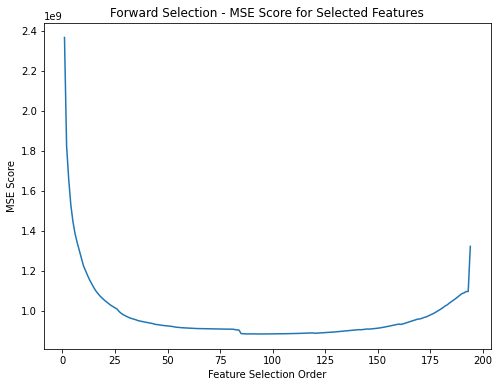

In [87]:
#去除score[]的最後兩個值
trimmed_scores = scores[:-10]

# 获取特征选择的顺序位置列表
feature_order = list(range(1, len(trimmed_scores) + 1))

# 创建一个大尺寸的图形
plt.figure(figsize=(8, 6))

# 绘制折线图
plt.plot(feature_order, trimmed_scores)
plt.xlabel("Feature Selection Order")
plt.ylabel("MSE Score")
plt.title("Forward Selection - MSE Score for Selected Features")
plt.show()

In [278]:
selected_features_subset_forward = selected_features[:min_index]

In [211]:
test_1_new = test_1[selected_features_subset]
data_1_x = data_1[selected_features_subset]
data_1_y=data_1['SalePrice']

## backward selection

In [258]:
#越前面的值是越早被移除的
def backward_selection(X, y, cv_folds):
    selected_features = list(X.columns)
    best_score = np.inf
    
    # 初始化模型和评分记录
    model = LinearRegression()
    scores = []
    selected_features_record = []
    
    while len(selected_features) > 1:
        worst_feature = None
        worst_feature_score = np.inf
        
        # 在当前选择的特征中找到最差的特征
        for feature in selected_features:
            features_subset = selected_features.copy()
            features_subset.remove(feature)
            X_subset = X[features_subset]
            
            # 使用交叉验证计算MSE
            mse_scores = -cross_val_score(model, X_subset, y, cv=cv_folds, scoring='neg_mean_squared_error')
            avg_mse = np.mean(mse_scores)
            
            # 更新最差特征和分数
            if avg_mse < worst_feature_score:
                worst_feature = feature
                worst_feature_score = avg_mse
        
        # 将最差特征从已选择的特征列表中移除
        selected_features.remove(worst_feature)
        scores.append(worst_feature_score)
        selected_features_record.append(worst_feature)

        # 打印每次选择的特征和评分
        print("Removed Feature: {}, MSE Score: {}".format(worst_feature, worst_feature_score)) 
        
        # 更新最佳分数
        if worst_feature_score < best_score:
            best_score = worst_feature_score
    
    if len(selected_features) == 1:
        selected_features_record.append(selected_features)


    return selected_features_record, scores

# 进行特征选择
selected_features_record, scores = backward_selection(data_1_x, data_1_y, cv_folds=3)

# 打印每次选择的特征和评分
for feature, score in zip(selected_features, scores):
    print("Removed Feature: {}, MSE Score: {}".format(feature, score))



Removed Feature: CompShg, MSE Score: 1173249485.11669
Removed Feature: IR2, MSE Score: 1148356753.6515226
Removed Feature: CmentBd, MSE Score: 1131075911.8006544
Removed Feature: ConLI, MSE Score: 1117415871.4752986
Removed Feature: 4, MSE Score: 1105550653.0873578
Removed Feature: IR3, MSE Score: 1096232049.7955322
Removed Feature: Unf, MSE Score: 1088069027.955942
Removed Feature: Rec, MSE Score: 1079783727.9110105
Removed Feature: PosA, MSE Score: 1072513042.1747955
Removed Feature: Metal, MSE Score: 1065466532.3213015
Removed Feature: FullBath, MSE Score: 1059119241.8902569
Removed Feature: 20, MSE Score: 1053592729.6179765
Removed Feature: 75, MSE Score: 1046407081.8485664
Removed Feature: OpenPorchSF, MSE Score: 1041547201.9685379
Removed Feature: PosN, MSE Score: 1036914253.9671341
Removed Feature: TotRmsAbvGrd, MSE Score: 1032328972.6931528
Removed Feature: AdjLand, MSE Score: 1028226513.9526755
Removed Feature: Crawfor, MSE Score: 1023427001.2147168
Removed Feature: Reg, MSE S

In [260]:
selected_features_subset = selected_features[:203]


In [263]:
selected_features_record[203] = 'OverallQual'

In [264]:
selected_features_record

['CompShg',
 'IR2',
 'CmentBd',
 'ConLI',
 '4',
 'IR3',
 'Unf',
 'Rec',
 'PosA',
 'Metal',
 'FullBath',
 '20',
 '75',
 'OpenPorchSF',
 'PosN',
 'TotRmsAbvGrd',
 'AdjLand',
 'Crawfor',
 'Reg',
 'MeadowV',
 '11',
 'CulDSac',
 'Family',
 'Feedr',
 '7',
 'BLQ',
 'Grav',
 'Sev',
 '5',
 'Stucco',
 'None',
 'BrkComm',
 'CemntBd',
 'CWD',
 'Y',
 'VinylSd',
 'Plywood',
 'Wd Sdng',
 'Con',
 'Somerst',
 'GarageArea',
 'Veenker',
 'Inside',
 'Partial',
 'Brk Cmn',
 '2007',
 '30',
 'PoolArea',
 '80',
 'RRAn',
 '3',
 'Tar&Grv',
 'Mansard',
 'PConc',
 'Membran',
 '70',
 'WdShing',
 'WD',
 '160',
 '2008',
 'OthW',
 'YearRemodAdd',
 'Normal',
 'Timber',
 '2.5Unf',
 'CarPort',
 '2009',
 'ConLw',
 'Shed',
 'Mix',
 '40',
 '2fmCon',
 'MetalSd',
 'Other',
 'Oth',
 '190',
 'SLvl',
 '2Story',
 'MiscVal',
 'SFoyer',
 'Alloca',
 'Min1',
 'Min2',
 'FuseP',
 '2010',
 'CBlock',
 'HalfBath',
 '85',
 'FuseF',
 'Roll',
 'Blueste',
 'SBrkr',
 'Gable',
 'Hip',
 'RRNn',
 'Gambrel',
 'BrkCmn',
 'GLQ',
 'BrDale',
 'AsphSh

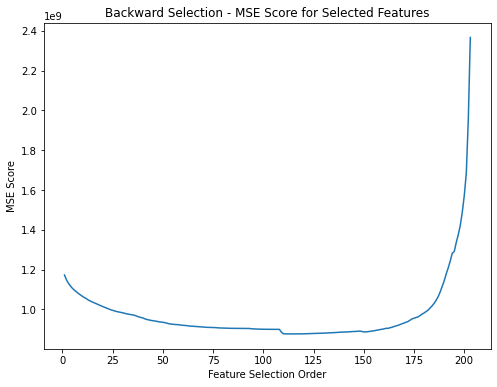

In [265]:
#去除score[]的最後兩個值
#trimmed_scores = scores[:-2]

# 获取特征选择的顺序位置列表
feature_order = list(range(1, len(scores) + 1))

# 创建一个大尺寸的图形
plt.figure(figsize=(8, 6))

# 绘制折线图
plt.plot(feature_order, scores)
plt.xlabel("Feature Selection Order")
plt.ylabel("MSE Score")
plt.title("Backward Selection - MSE Score for Selected Features")
plt.show()

In [266]:
#因為最前面的feature是最先被丟掉的，轉過來，選擇最後被丟掉的那些feature
scores.reverse()
selected_features_record.reverse()

# 找到最小值及其索引
min_score = np.min(scores)
min_index = np.argmin(scores)

# 输出结果
print("最小的MSE Score为:", min_score)
print("对应的索引为:", min_index)

最小的MSE Score为: 876768426.4850696
对应的索引为: 87


In [267]:
for i in range(min_index):
    print(selected_features_record[i])

OverallQual
1stFlrSF
2ndFlrSF
YearBuilt
NridgHt
BsmtFullBath
OverallCond
StoneBr
NoRidge
TA
Gd
WdShngl
Twnhs
TwnhsE
GarageCars
Norm
KitchenAbvGr
New
LotArea
BrkFace
Typ
Fireplaces
GarageYrBlt
Edwards
No
FV
Pave
Mod
Lvl
LotFrontage
HLS
ScreenPorch
60
BedroomAbvGr
OldTown
Slab
Mitchel
NWAmes
MasVnrArea
NAmes
Wd Shng
RL
RM
RH
Gilbert
Sawyer
1Story
CollgCr
Mn
ConLD
Fa
HdBoard
BsmtHalfBath
BuiltIn
Attchd
Detchd
Basment
NoSeWa
GasA
Wall
GasW
RRAe
IDOTRR
SawyerW
SWISU
BrkSide
1.5Unf
50
Wood
2
ClearCr
LowQualFinSF
2.5Fin
FR3
8
12
RFn
Stone
Low
FR2
10
6
9
45
RRNe
P
180


In [279]:
selected_features_subset_backward = selected_features[:min_index]
test_1_new = test_1[selected_features_subset]
data_1_x = data_1[selected_features_subset]
data_1_y=data_1['SalePrice']

## common feature between forward & backward 

In [282]:
# 将两个列表转换为集合
selected_features_subset_forward = set(selected_features_subset_forward)
selected_features_subset_backward = set(selected_features_subset_backward)

# 找出共同的特征
common_features = selected_features_subset_forward.intersection(selected_features_subset_backward)

# 将共同的特征转换为列表
common_features_list = list(common_features)

print(common_features_list)

['BLQ', 'NAmes', 'Somerst', 'Con', 'RL', 'Metal', 'Mn', 'Veenker', 'GarageArea', 'Twnhs', '90', 'Wd Shng', 'Gilbert', 'GasA', 'OverallQual', '12', 'HdBoard', '1stFlrSF', '9', 'P', 'FR3', 'Crawfor', 'RM', '2.5Fin', 'BrkComm', '30', 'FR2', 'Maj2', 'MiscVal', 'SLvl', '2008', 'BrkFace', 'SawyerW', 'Feedr', 'CulDSac', 'EnclosedPorch', 'LwQ', 'Attchd', 'SBrkr', 'GLQ', '7', 'Blueste', '2010', '5', 'Inside', 'Basment', '50', 'No', 'New', 'Stone', 'Membran', 'BrkSide', 'KitchenAbvGr', 'RFn', 'Edwards', 'TotalBsmtSF', 'WoodDeckSF', 'ImStucc', 'Alloca', 'Timber', 'PConc', 'CemntBd', '180', '190', 'Mansard', 'BsmtFullBath', '6', '2', 'Stucco', 'Slab', '8', '3SsnPorch', 'Gd', 'OldTown', 'Oth', 'VinylSd', 'Gable', 'Shed', 'GarageYrBlt', 'YearBuilt', 'Sev', '75', 'RRAe', 'FuseF', 'Min1', 'Min2', 'RRAn', 'PosN', 'IR2', 'Lvl', 'NPkVill', 'Duplex', '3', 'Wd Sdng', 'Y', 'AdjLand', 'Unf', 'Pave', 'ConLI', '11', 'BsmtUnfSF', 'WdShngl', 'Rec', 'CmentBd', '70', 'MetalSd', 'BrkCmn', 'BsmtFinSF1', 'WdShake', '

In [283]:
len(common_features_list)

204

## prediction

In [269]:
import xgboost
from sklearn.model_selection import RandomizedSearchCV
regressor = xgboost.XGBRegressor()

In [270]:
regressor.fit(data_1_x, data_1_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [271]:
y_pred = regressor.predict(test_1_new)

In [272]:
##Create Sample Submission file and Submit using ANN
pred=pd.DataFrame(y_pred)
#sub_df=pd.read_csv('formulatedtest.csv')
datasets=pd.concat([test['Id'],pred],axis=1)
datasets.columns=['Id','SalePrice']

### output to .csv

In [275]:
datasets.to_csv('backward_selection.csv',index=False)

In [274]:
datasets.head()

,Id,SalePrice
0,1461,101867.921875
1,1462,157314.046875
2,1463,192006.593750
3,1464,193493.078125
4,1465,178867.531250
